In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import pandas as pd

def read_data(filename):
    # read in csv
    df = pd.read_csv('/content/drive/MyDrive/articles_with_bias.csv')
    
    
    df.dropna(subset=['Text'],inplace=True)
    df = df.drop('Unnamed: 0', axis = 1)

    df['Sentences'] = [t.count('.') for t in df['Text']]
    
    #convert bias label to numbers
    df['Bias'] = df['Bias'].replace({'Lean Left': 1, 'Center': 2, 'Lean Right':3, 'Right': 4})
    
    
    return df

In [8]:
new = read_data('/content/drive/MyDrive/articles_with_bias.csv')
new.head()

,Title,Text,Source,Bias,Text_length,Sentences
0,Michigan wants to lead U.S. in electric vehicl...,The Dearborn-based automaker chose Tennessee f...,Bridgemi,4,1248.0,52
1,Republicans’ hold on Lansing power could grow ...,"From a purely geographic perspective, most of ...",Bridgemi,4,331.0,17
2,Dueling gatherings highlight split as Michigan...,“The focus of the last election is always goin...,Bridgemi,4,371.0,21
3,Michigan counties dump mask rules for thousand...,"Marquette, Ottawa, Washtenaw and Kent county h...",Bridgemi,4,1500.0,82
4,Gov. Gretchen Whitmer signs $70B Michigan budg...,"The finalized legislation, brokered by Whitmer...",Bridgemi,4,1363.0,66


In [9]:
!pip install textstat

     |████████████████████████████████| 101 kB 6.2 MB/s 
     |████████████████████████████████| 2.0 MB 70.1 MB/s 


In [10]:
from textstat.textstat import textstat

def read_score(text):
  text = textstat.automated_readability_index(text.replace('\n',''))
  return text

In [11]:
read_score(new['Text'][1])

84.3

In [12]:
reading_list = [read_score(t) for t in new.Text]
new["Reading"] = reading_list

In [13]:
new['Length'] = [len(t.split()) for t in new['Text']]
new=new.drop("Text_length",axis=1)

In [14]:
new.head()

,Title,Text,Source,Bias,Sentences,Reading,Length
0,Michigan wants to lead U.S. in electric vehicl...,The Dearborn-based automaker chose Tennessee f...,Bridgemi,4,52,72.0,1248
1,Republicans’ hold on Lansing power could grow ...,"From a purely geographic perspective, most of ...",Bridgemi,4,17,84.3,331
2,Dueling gatherings highlight split as Michigan...,“The focus of the last election is always goin...,Bridgemi,4,21,29.2,371
3,Michigan counties dump mask rules for thousand...,"Marquette, Ottawa, Washtenaw and Kent county h...",Bridgemi,4,82,36.3,1500
4,Gov. Gretchen Whitmer signs $70B Michigan budg...,"The finalized legislation, brokered by Whitmer...",Bridgemi,4,66,41.7,1363


In [15]:
new.to_csv('/content/drive/MyDrive/updated_bias_articles.csv')

In [16]:
df=new.copy()

In [17]:
df['Bias'] = df['Bias'].replace({1:'Left', 2:'Center', 3:'Lean Right', 4:'Right'})
df.head()

,Title,Text,Source,Bias,Sentences,Reading,Length
0,Michigan wants to lead U.S. in electric vehicl...,The Dearborn-based automaker chose Tennessee f...,Bridgemi,Right,52,72.0,1248
1,Republicans’ hold on Lansing power could grow ...,"From a purely geographic perspective, most of ...",Bridgemi,Right,17,84.3,331
2,Dueling gatherings highlight split as Michigan...,“The focus of the last election is always goin...,Bridgemi,Right,21,29.2,371
3,Michigan counties dump mask rules for thousand...,"Marquette, Ottawa, Washtenaw and Kent county h...",Bridgemi,Right,82,36.3,1500
4,Gov. Gretchen Whitmer signs $70B Michigan budg...,"The finalized legislation, brokered by Whitmer...",Bridgemi,Right,66,41.7,1363


In [18]:

# clip dataset of overly short / lengthy texts
df = df[df.Length > 50]
df = df[df.Length < 2500]

In [19]:
from sklearn import preprocessing, tree
import copy

new_tree = copy.deepcopy(df)

encode = preprocessing.LabelEncoder()
encode.fit(new_tree['Source'].values.tolist())

new_tree['Source'] = encode.transform(new_tree['Source'].values.tolist())

In [20]:
features = new_tree.loc[:, ['Source', 'Sentences', 'Reading']]
outcomes = new_tree.loc[:, ['Bias']]
features.head()

,Source,Sentences,Reading
0,1,52,72.0
1,1,17,84.3
2,1,21,29.2
3,1,82,36.3
4,1,66,41.7


In [21]:
import numpy as np
outcomes_target_names = np.asarray(['Left', 'Center','Lean Right','Right'])

In [22]:
newsy = {'data': features.values, 'feature_names':list(features.columns.values), 'target':outcomes.values, 'target_names':outcomes_target_names}

In [23]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(newsy['data'], newsy['target'])

In [24]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("newsy")

'newsy.pdf'

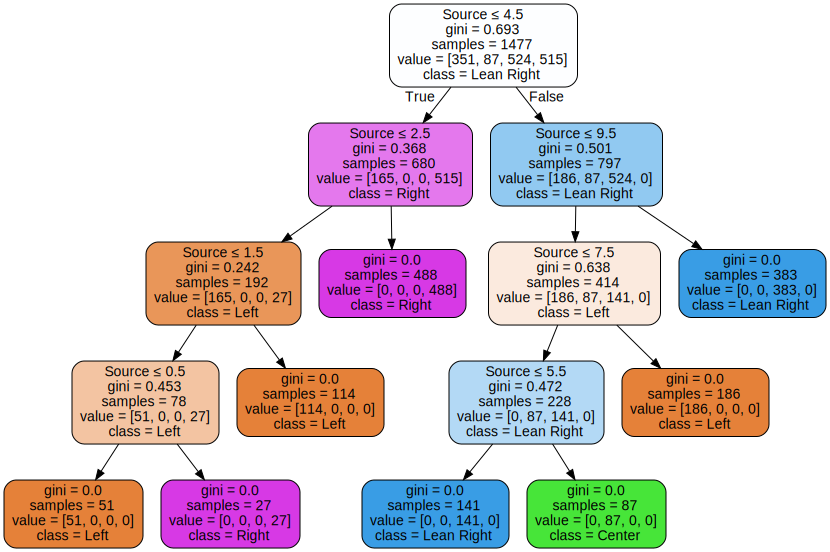

In [25]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=newsy['feature_names'],  
                         class_names=newsy['target_names'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [26]:
graph.render("newsy")

'newsy.pdf'

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
features2 = new_tree.loc[:, ['Source']]
outcomes2 = new_tree.loc[:, ['Bias']]

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, outcomes2, test_size = 0.2, random_state = 100)
outcomes2_target_names = np.asarray(['Left', 'Center', 'Lean Right','Right'])

In [31]:
newsy = {'data': features2.values, 'feature_names':list(features2.columns.values), 'target':outcomes2.values, 'target_names':outcomes2_target_names}

In [32]:
clf = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=100, min_samples_leaf=1)
clf = clf.fit(X_train2, y_train2)

In [33]:
clf_gini = tree.DecisionTreeClassifier(class_weight=None, criterion='gini',
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=True, random_state=100, splitter='best')
clf_gini = clf_gini.fit(X_train2, y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


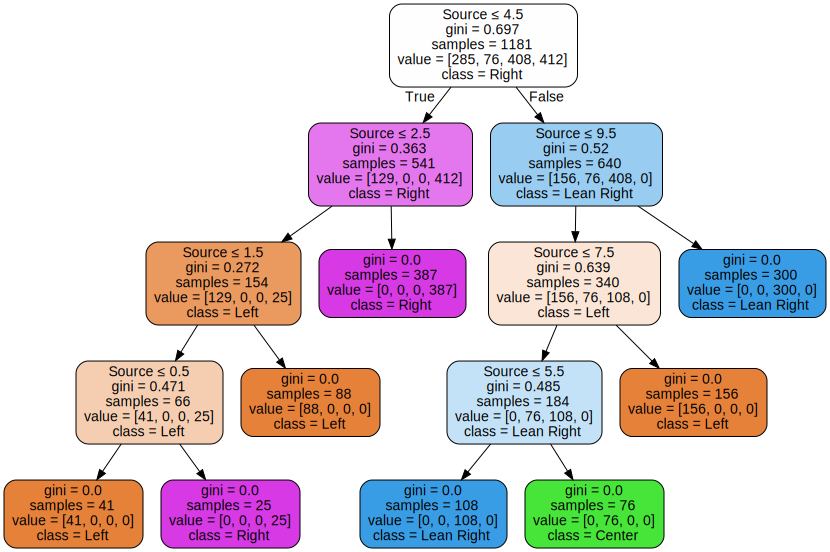

In [34]:

import graphviz 
dot_data2 = tree.export_graphviz(clf_gini, out_file=None, 
                         feature_names=newsy['feature_names'],  
                         class_names=newsy['target_names'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph2 = graphviz.Source(dot_data2)  
graph2

In [ ]:
y_pred = clf_gini.predict(X_test)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  100.0


In [ ]:
graph.render("newsy2")

'newsy2.pdf'